<a href="https://colab.research.google.com/github/Varfalamei/Semantic_segmentation_ADDI/blob/main/Semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


Датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>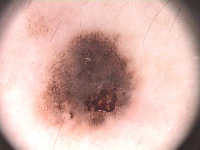</td><td>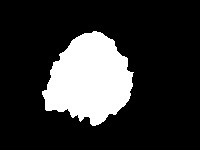</td></tr></table>


Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
# ! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
!wget https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2021-05-03 08:31:46--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2021-05-03 08:31:46--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf3fc191dbabbe43663bab08172.dl.dropboxusercontent.com/cd/0/inline/BNxTZd8jYEDDnIj5ZpC1lqXnk8Mg-V6r5qnMNQGI9aJo931zKXpomHQtrnoSm8H_DznnIwHw3xL1yEUWK0Cm0XxDJ5eJklk8J0sSidnHOw1HMg6_A1eIRDHe_W0XESQRX0W8D8x4EZ0bAJ2Jko6RAsXq/file# [following]
--2021-05-03 08:31:46--  https://ucf3fc191dbabbe43663bab08172.dl.dropboxusercontent.com/cd/0/inline/BNxTZd8jYEDDnIj5ZpC1lqXnk8Mg-V6r5qnMNQGI9aJo931zKXpomHQtrnoSm8H_DznnIwHw3xL1yEUWK0Cm

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

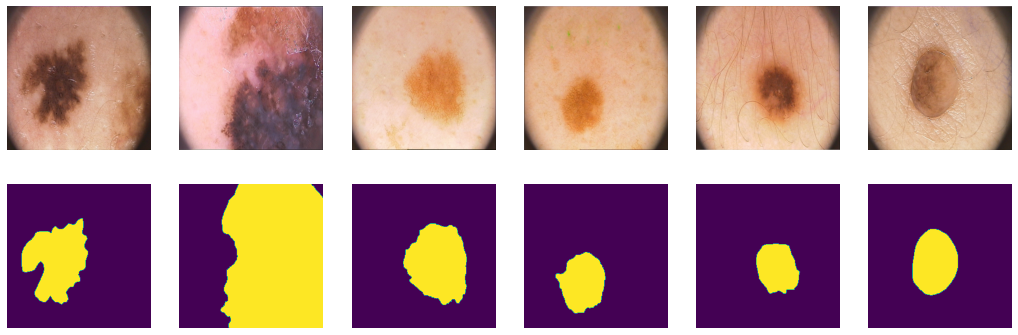

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
X_train = np.concatenate([X[tr], X[tr], X[tr]])
Y_train = np.concatenate([Y[tr], Y[tr], Y[tr]])
from PIL import ImageOps
import random
for i in range(X_train.shape[0]):
    if i > 100:
        X_train[i] = np.flip(X_train[i], axis=0)
        Y_train[i] = np.flip(Y_train[i], axis=0)
    if i > 200:
        X_train[i] = np.flip(X_train[i], axis=1)
        Y_train[i] = np.flip(Y_train[i], axis=1)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25

data_tr = DataLoader(list(zip(np.rollaxis(X_train, 3, 1), Y_train[np.newaxis].reshape([-1, 1, 256, 256]))), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    axes[0].plot(history['epoch'], history['train_loss'], label='train_loss')
    axes[0].plot(history['epoch'], history['val_loss'], label='val_loss')
    axes[1].plot(history['epoch'], history['val_score'], label='val_score')
    for i in [0,1]: axes[i].legend()

# Реализация различных архитектур:
Задание состоит в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet 

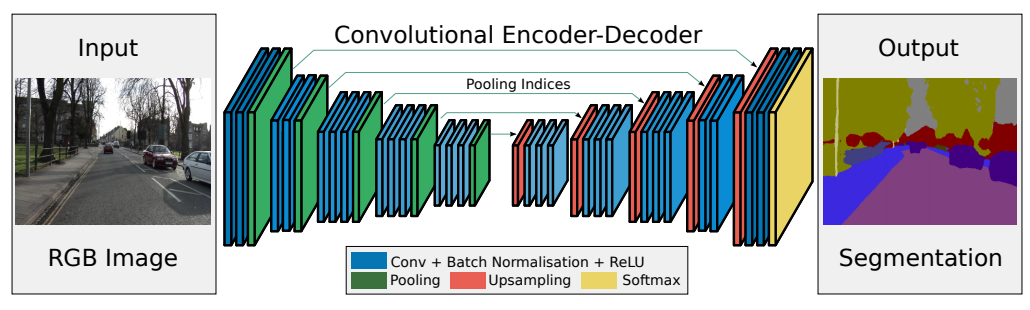

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool0 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            )
        self.pool3 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)# 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            )
        
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)# 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)# 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            )
    def forward(self, x):
        # encoder
        e0, indices_e0 = self.pool0(self.enc_conv0(x))
        e1, indices_e1 = self.pool1(self.enc_conv1(e0))
        e2, indices_e2 = self.pool2(self.enc_conv2(e1))
        e3, indices_e3 = self.pool3(self.enc_conv3(e2))
        # bottleneck
        b = self.bottleneck_conv(e3)
        
        # decoder
        d0 = self.dec_conv0(self.upsample0(b, indices_e3))
        d1 = self.dec_conv1(self.upsample1(d0, indices_e2))
        d2 = self.dec_conv2(self.upsample2(d1, indices_e1))
        d3 = self.dec_conv3(self.upsample3(d2, indices_e0))  # no activation
        return d3

-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

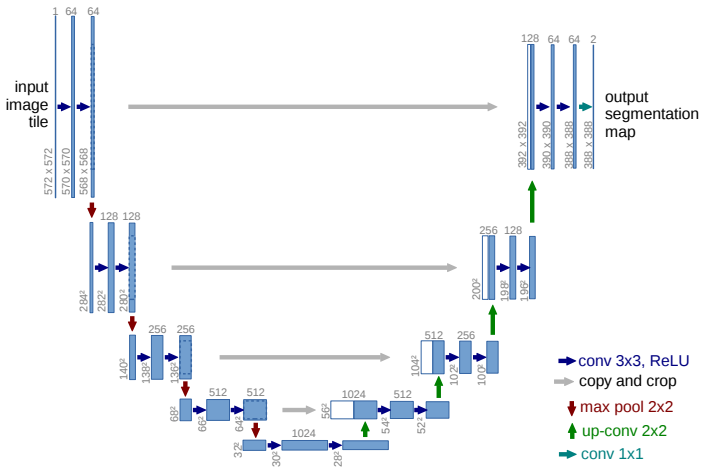

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool0 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)# 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)# 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)# 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1),
            )
    def forward(self, x):
        # encoder
        
        enc0 = self.enc_conv0(x)
        pool0, indices_e0 = self.pool0(enc0)
        enc1 = self.enc_conv1(pool0)
        pool1, indices_e1 = self.pool1(enc1)
        enc2 = self.enc_conv2(pool1)
        pool2, indices_e2 = self.pool2(enc2)
        enc3 = self.enc_conv3(pool2)
        pool3, indices_e3 = self.pool3(enc3)
        
        # bottleneck
        b = self.bottleneck_conv(pool3)
        
        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b, indices_e3), enc3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0, indices_e2), enc2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1, indices_e1), enc1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2, indices_e0), enc0), dim=1))
        # no activation
        return d3

Новая модель путем изменения типа пулинга:


Заменяем max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            ) # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            ) # 64 -> 32 

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            ) # 32 -> 16
        
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            )

        # decoder (upsampling)
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, output_padding=1, padding=1), # 16 -> 32
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, output_padding=1, padding=1), # 32 -> 64
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, output_padding=1, padding=1), # 64 -> 128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, output_padding=1, padding=1), # 128 -> 256
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1),
            )
    def forward(self, x):
        # encoder
        enc0 = self.enc_conv0(x)
        enc1 = self.enc_conv1(enc0)
        enc2 = self.enc_conv2(enc1)
        enc3 = self.enc_conv3(enc2)

        # bottleneck
        b = self.bottleneck_conv(enc3)

        # decoder
        d0 = self.dec_conv0(torch.cat((b, enc3), dim=1))
        d1 = self.dec_conv1(torch.cat((d0, enc2), dim=1))
        d2 = self.dec_conv2(torch.cat((d1, enc1), dim=1))
        d3 = self.dec_conv3(torch.cat((d2, enc0), dim=1))
        
        # no activation
        return d3

## Метрика


$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(labels: torch.Tensor, outputs: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    # please don't use nn.BCELoss. write it from scratch
    return (y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred))).mean()

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred, smooth=1e-7):
    inputs = torch.sigmoid(y_pred)       
    inputs = inputs.view(-1)
    targets = y_real.view(-1)
    intersection = (inputs * targets).sum()                            
    dice = (2. * intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  

    return 1 - dice

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_true, y_pred, eps = 1e-8, gamma = 2, alpha = 0.8):
    inputs = torch.sigmoid(y_pred)       
    
    #flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = y_true.view(-1)
    #first compute binary cross-entropy 
    BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
    BCE_EXP = torch.exp(-BCE)
    focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                    
    return focal_loss

In [ ]:
def tversky_loss(y_true, y_pred, alpha=0.5, beta=0.5, smooth=1e-8):
    y_pred = torch.sigmoid(y_pred.flatten())
    y_true = y_true.flatten()
    intersection = (y_pred * y_true).sum()
    fps = (y_pred * (1 - y_true)).sum()
    fns = ((1 - y_pred) * y_true).sum()
    denom = intersection + (alpha * fps) + (beta * fns)
    tversky_loss = ((intersection + smooth) / (denom + smooth)).mean()
    return (1 - tversky_loss)


## Тренировка

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    history = {'epoch':[],'train_loss':[],'val_loss':[],'val_score':[]}
    X_val, Y_val = next(iter(data_val))
    sch = torch.optim.lr_scheduler.StepLR(opt, step_size=15, gamma=0.75, last_epoch=-1, verbose=False)

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.cuda(), Y_batch.cuda()
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step() # update weights
            sch.step()  
  
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        toc = time()
        print('loss: %f' % avg_loss)
        
        

        # show intermediate results
        Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu
        val_score = iou_pytorch(Y_val, Y_hat > 0.5).mean()
        val_loss = loss_fn(Y_val, Y_hat)
        lr = opt.param_groups[0]['lr']

        history['epoch'].append(epoch)
        history['train_loss'].append(avg_loss.item())
        history['val_loss'].append(val_loss.item())
        history['val_score'].append(val_score.item())

        # Visualize tools
        clear_output(wait=True)
        fig = plt.figure(figsize=(14, 9))
        # fig.suptitle((f'epoch: {epoch + 1} / {epochs}, '
        #               f'lr: {lr:.5f}, train_loss: {avg_loss:.5f}, '
        #               f'val_loss: {val_loss:.5f}, val_score: {val_score:.3f}'))
        for k in range(6):
            
            plt.subplot(4, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real X')
            plt.axis('off')

            plt.subplot(4, 6, k+7)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('Real Y')
            plt.axis('off')

            plt.subplot(4, 6, k+13)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(4, 6, k+19)
            plt.imshow((Y_hat[k, 0] > 0.5).int(), cmap='gray')
            plt.title('Output th 0.5')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

       
    print('The result on validation was {:.3f}'.format(score_model(model, iou_pytorch, data_val)))
    plot_history(history)

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0

    for X_batch, Y_label in data:
        Y_pred = (model(X_batch.to(device)) > 0.5).int()
        scores += metric(Y_label.to(device), Y_pred).mean().item()
    return scores/len(data)

## Основной момент: обучение



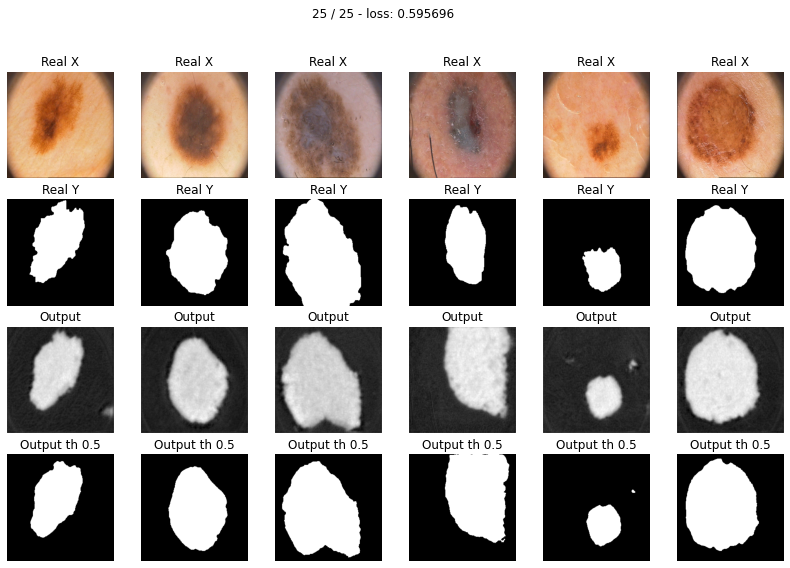

The result on validation was 0.684


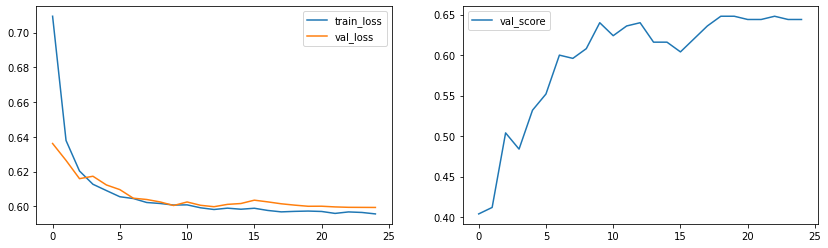

In [ ]:
SegNet_bce_loss = SegNet().to(device)
train(SegNet_bce_loss, torch.optim.Adam(SegNet_bce_loss.parameters()), bce_loss, 25, data_tr, data_val)

Проводим тестирование:

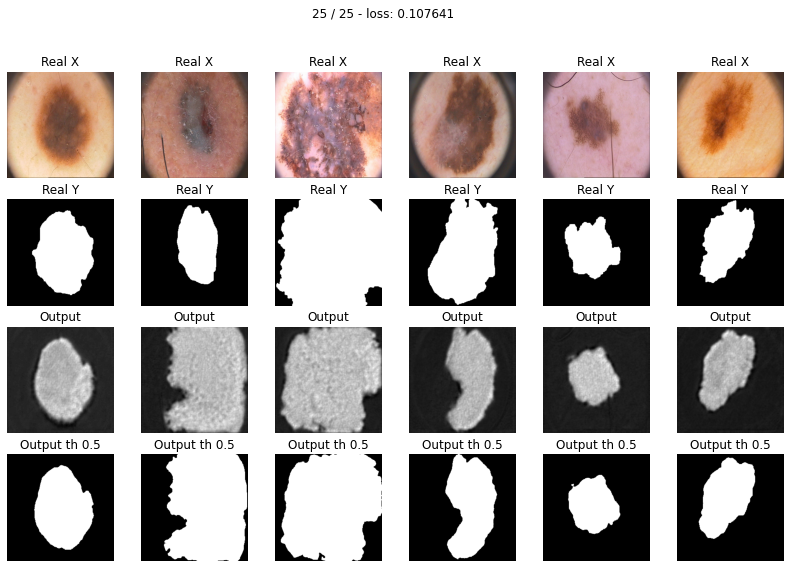

The result on validation was 0.654


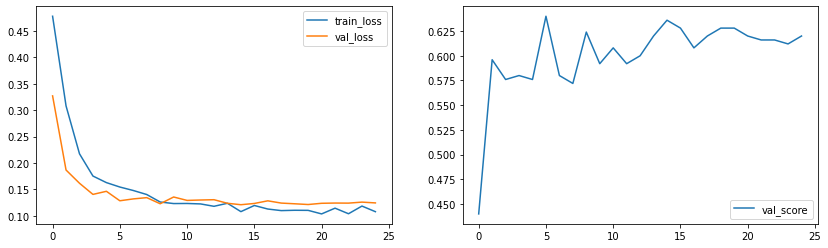

In [ ]:
SegNet_dice_loss = SegNet().to(device)
train(SegNet_dice_loss, torch.optim.Adam(SegNet_dice_loss.parameters()), dice_loss, 25, data_tr, data_val)

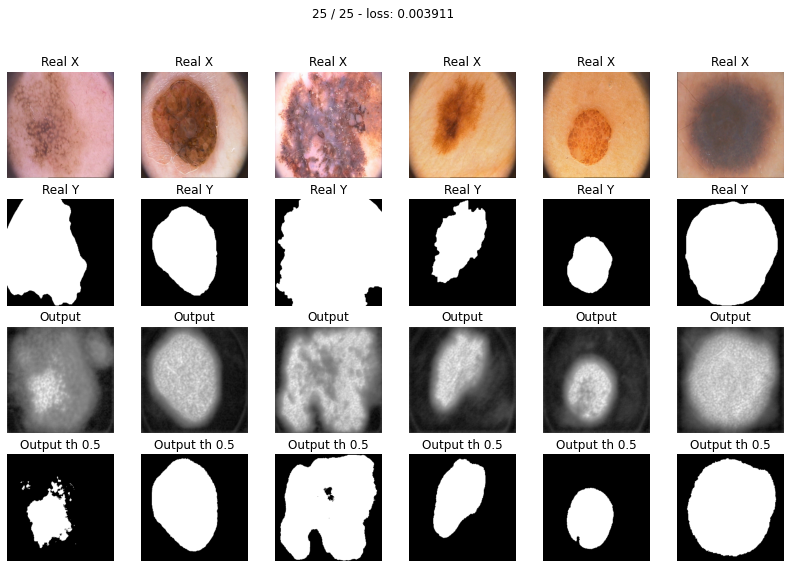

The result on validation was 0.658


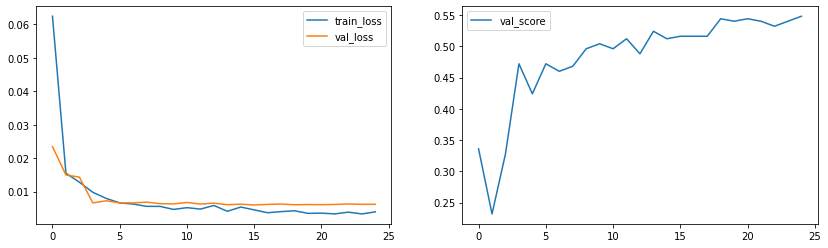

In [ ]:
SegNet_focal_loss = SegNet().to(device)
train(SegNet_focal_loss, torch.optim.Adam(SegNet_focal_loss.parameters()), focal_loss, 25, data_tr, data_val)

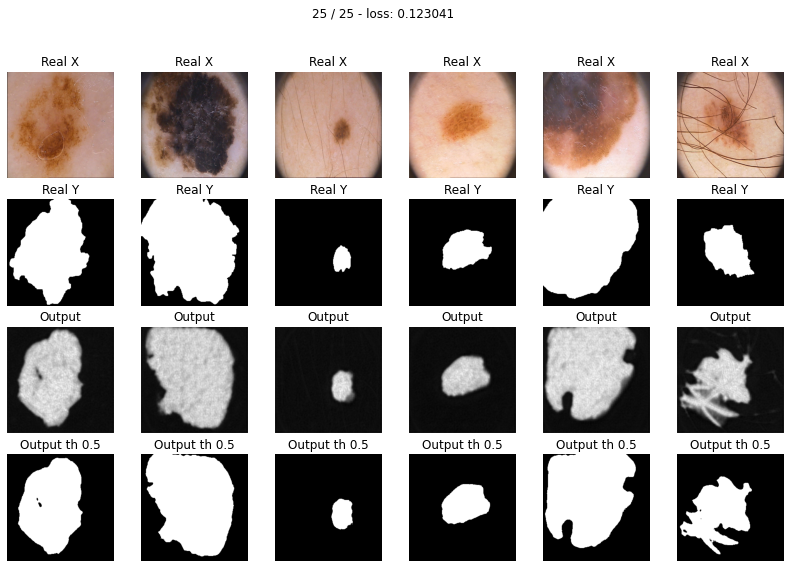

The result on validation was 0.658


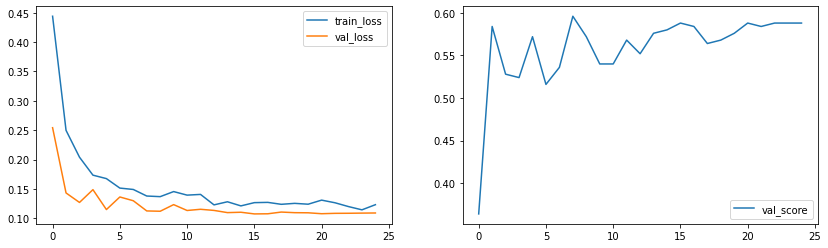

In [ ]:
SegNet_tversky_loss = SegNet().to(device)
train(SegNet_tversky_loss, torch.optim.Adam(SegNet_tversky_loss.parameters()), tversky_loss, 25, data_tr, data_val)

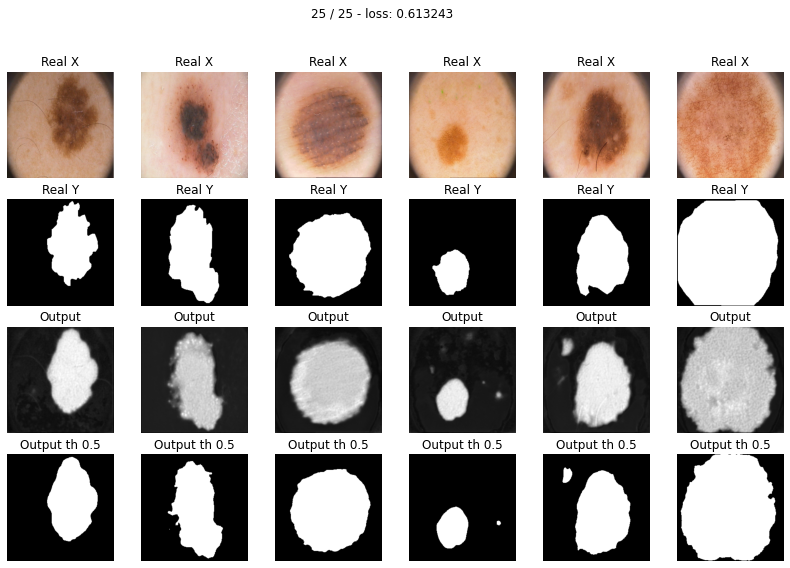

The result on validation was 0.730


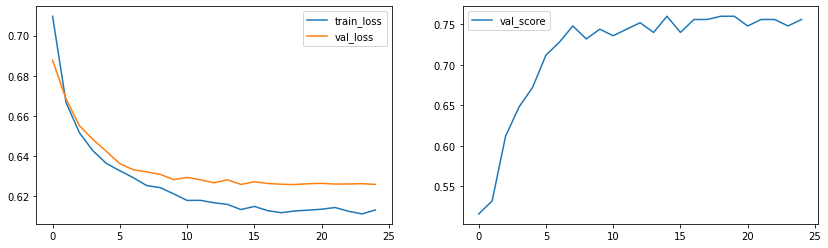

In [ ]:
torch.cuda.empty_cache()
unet_v1_bce_loss = UNet().to(device)
train(unet_v1_bce_loss, torch.optim.Adam(unet_v1_bce_loss.parameters()), bce_loss, 25, data_tr, data_val)

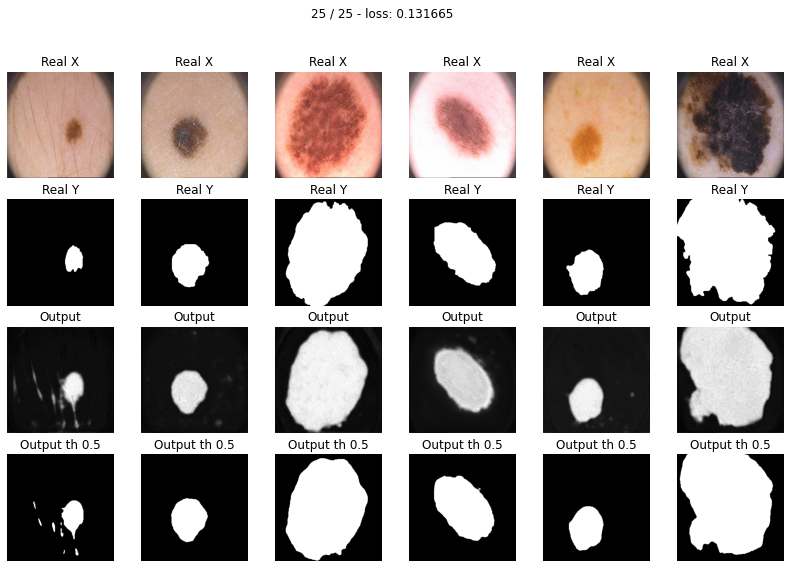

The result on validation was 0.656


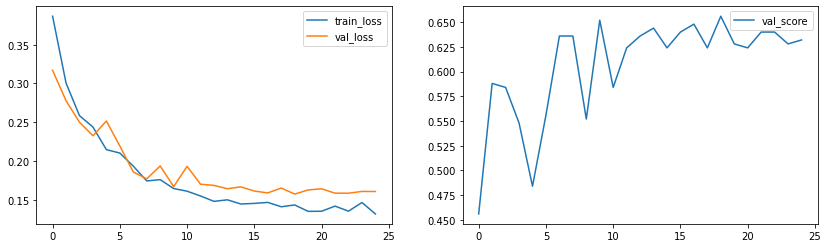

In [ ]:
torch.cuda.empty_cache()
unet_v1_dice_loss = UNet().to(device)
train(unet_v1_dice_loss, torch.optim.Adam(unet_v1_dice_loss.parameters()), dice_loss, 25, data_tr, data_val)

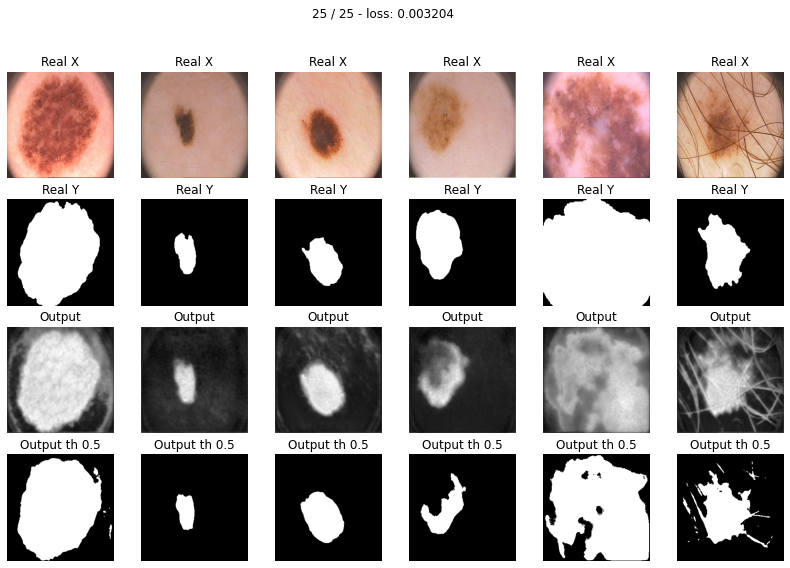

The result on validation was 0.698


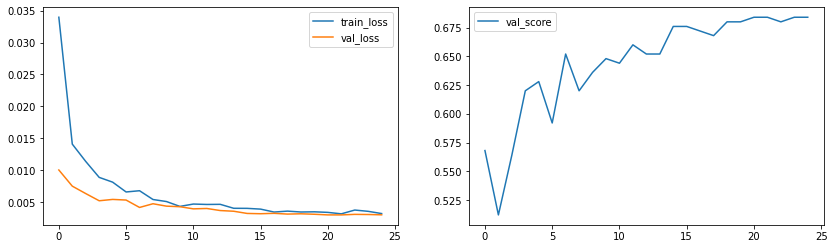

In [ ]:
torch.cuda.empty_cache()
unet_v1_focal_loss = UNet().to(device)
train(unet_v1_focal_loss, torch.optim.Adam(unet_v1_focal_loss.parameters()), focal_loss, 25, data_tr, data_val)

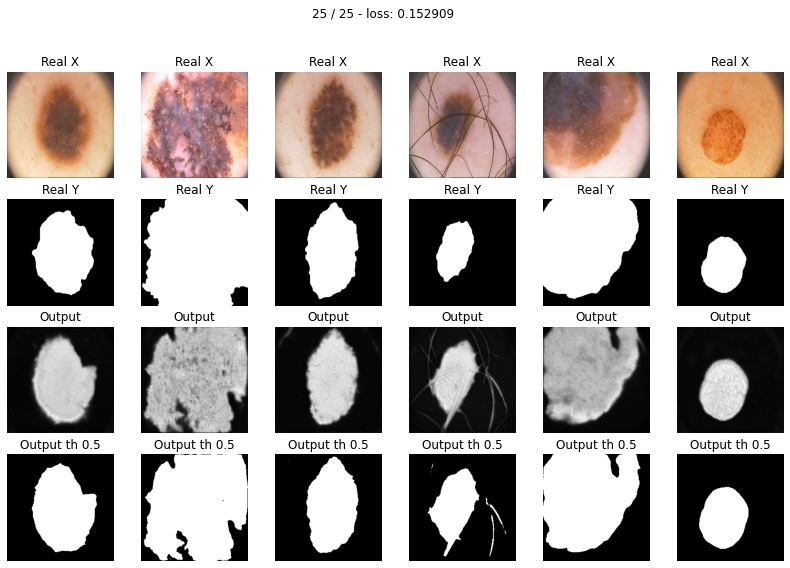

The result on validation was 0.680


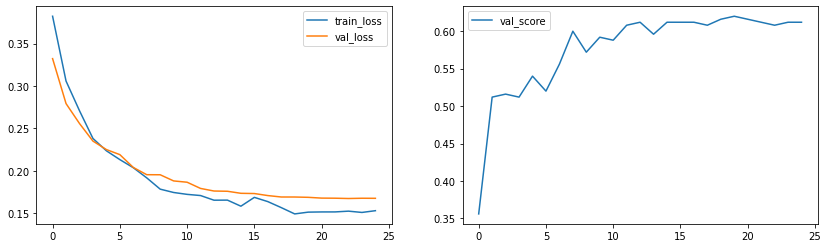

In [ ]:
torch.cuda.empty_cache()
unet_v1_tversky_loss = UNet().to(device)
train(unet_v1_tversky_loss, torch.optim.Adam(unet_v1_tversky_loss.parameters()), tversky_loss, 25, data_tr, data_val)

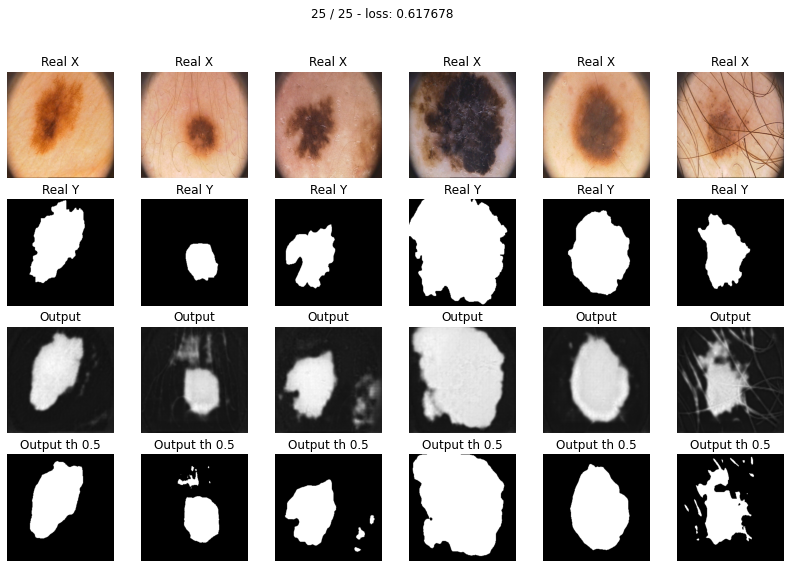

The result on validation was 0.700


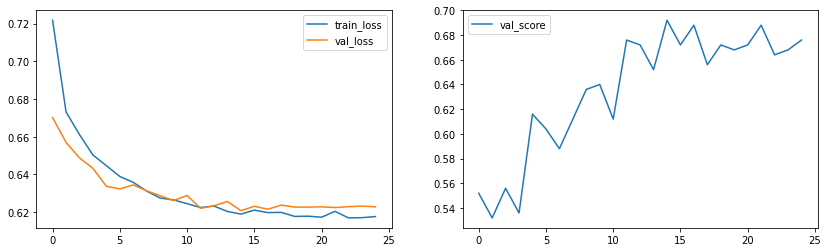

In [ ]:
torch.cuda.empty_cache()
unet_v2_bce_loss = UNet2().to(device)
train(unet_v2_bce_loss, torch.optim.Adam(unet_v2_bce_loss.parameters()), bce_loss, 25, data_tr, data_val)

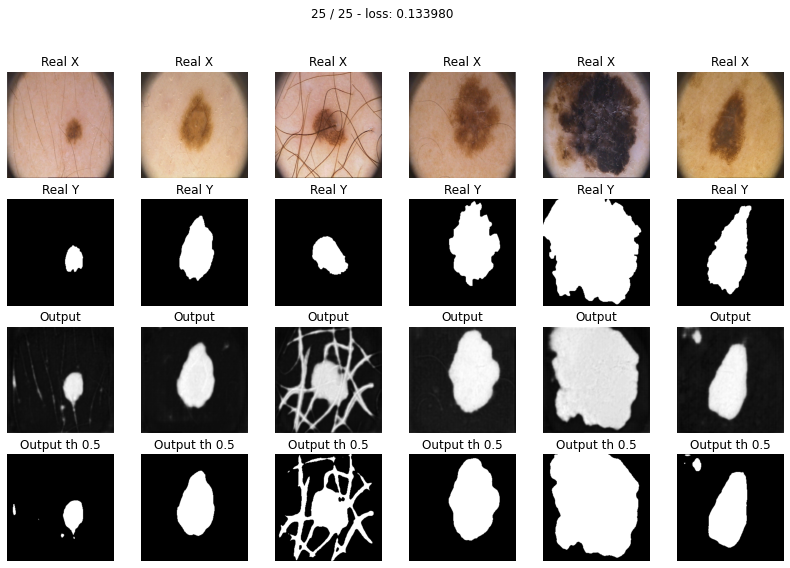

The result on validation was 0.656


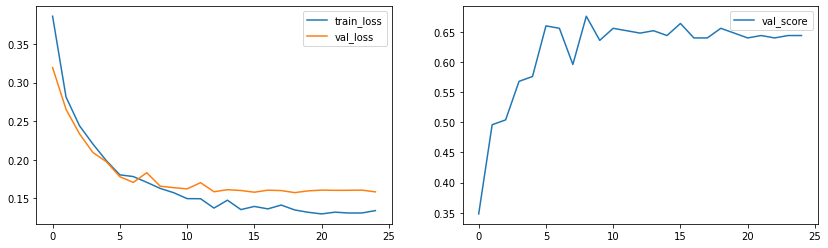

In [ ]:
torch.cuda.empty_cache()
unet_v2_dice_loss = UNet2().to(device)
train(unet_v2_dice_loss, torch.optim.Adam(unet_v2_dice_loss.parameters()), dice_loss, 25, data_tr, data_val)

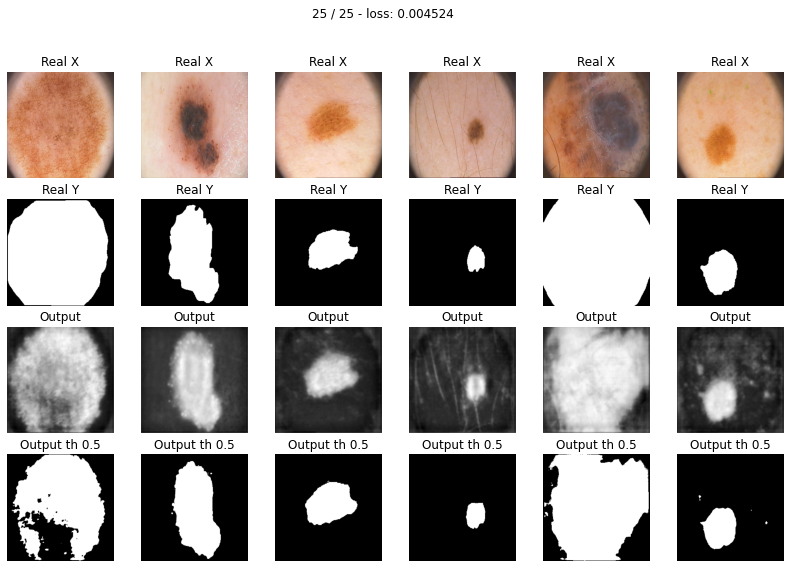

The result on validation was 0.688


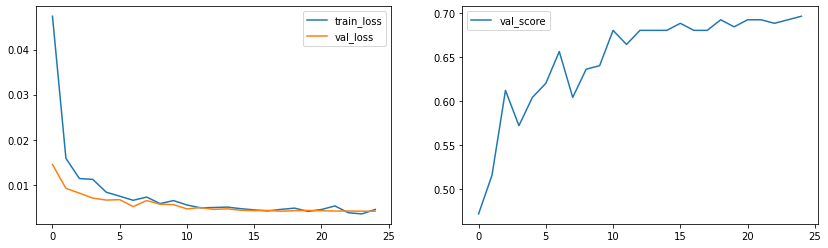

In [ ]:
torch.cuda.empty_cache()
unet_v2_focal_losss = UNet2().to(device)
train(unet_v2_focal_losss, torch.optim.Adam(unet_v2_focal_losss.parameters()), focal_loss, 25, data_tr, data_val)

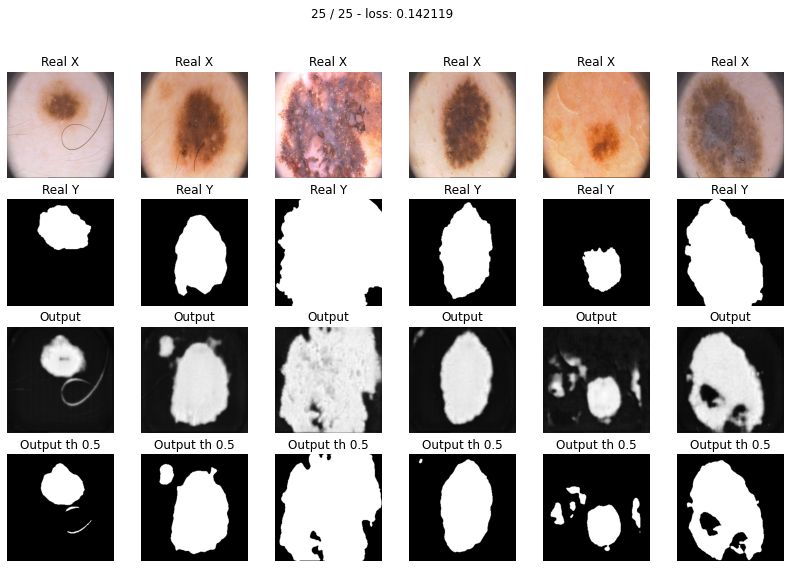

The result on validation was 0.640


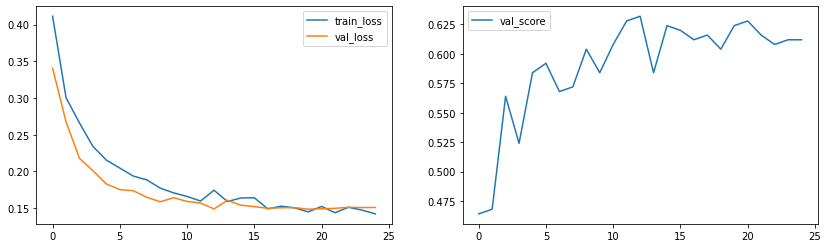

In [ ]:
torch.cuda.empty_cache()
unet_v2_tversky_loss = UNet2().to(device)
train(unet_v2_tversky_loss, torch.optim.Adam(unet_v2_tversky_loss.parameters()), tversky_loss, 25, data_tr, data_val)

In [ ]:
import pandas as pd
df = pd.DataFrame({'SegNet': [0.684, 0.654, 0.658, 0.658],
                   'UnetV1': [0.73, 0.656, 0.698, 0.68],
                   'UnetV2':[0.7, 0.656, 0.688, 0.64]},
                  index=['Bce', 'Dice', 'Focal', 'Tversky'])
df

SegNet  UnetV1  UnetV2
Bce       0.684   0.730   0.700
Dice      0.654   0.656   0.656
Focal     0.658   0.698   0.688
Tversky   0.658   0.680   0.640

In [ ]:
df.describe().loc[['mean', 'std', 'min', 'max'], :]

SegNet    UnetV1    UnetV2
mean  0.663500  0.691000  0.671000
std   0.013796  0.031177  0.027785
min   0.654000  0.656000  0.640000
max   0.684000  0.730000  0.700000

In [ ]:
df.T.describe().loc[['mean', 'std', 'min', 'max'], :]

Bce      Dice     Focal   Tversky
mean  0.704667  0.655333  0.681333  0.659333
std   0.023352  0.001155  0.020817  0.020033
min   0.684000  0.654000  0.658000  0.640000
max   0.730000  0.656000  0.698000  0.680000



# Результат


## Предисловие

Прежде всего необходимо указать, что модели обучались с аугментацией (трейн датасет был увеличен в 3 раза и повернут по нескольким осям),
все модели обучались на 25 бачах, соответственно некоторые модели могли недообучиться, а некоторые переобучиться.


## Вывод

Результат эксперимента мягко говоря неоднозначнный, некоторые модели кажутся немного нестабильными. Но есть модели, которые показали себя довольно хорошо, например, UnetV1 с bce loss. Остальные же модели показали себя +- одинаково в пределах погрешности.

Segnet в среднем показал себя немного хуже, чем его соперники со skip connection'ами. 

BCE loss неожиданно показал себя хорошо, что довольно странно, ведь он отдает предпочтение фоновому классу, возможно метрика подсчета не самая удачная для нашей задачи.